In [112]:
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import tables 
import pandas as pd
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity as cosine
from scipy import spatial
from sklearn import preprocessing
from scipy.spatial import distance
from pylab import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.stats import mode
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import classification_report, confusion_matrix  
from scipy import signal
import ipywidgets as widgets
from ipywidgets import interact
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support as score
%matplotlib inline

# Introduction #

Throughout this notebook I will be analyzing the simultaneous activity of ~10,000 neurons in the visual cortex of three mice. This data from the paper "High Dimensional Geometry of Population Responses in the Visual Cortex”, allowed Stringer et al to analyze the constraints on recognizing correlations in neural population codes. I read the introduction of their paper to familiarize myself with the data and then conducted my own data exploration and created my own models before reading further about their findings. After, I was able to ameliorate my own models and comment on the similarities and differences in what we both found.

I chose this dataset because we have talked quite extensively in class about the limitations of predicting the cause of neurons' activity. Through analyzing the mice's responses I explore the variability and similarity between individuals as well the dangers of dimensionality reduction and effect of population sizes. Towards the end of my analysis my models attempt to identify potential linear or non linear relationships in the data as well as predict the stimuli given the neural responses. Professor Gallant's paper on Non-linear relationships in the V1 was also useful when considering PCA and the non-linear approach to the neuron responses. Their research also trained on respones to natural images and illustrates how non-linear models have the potential to capture relationships between stimuli and neurons in the V1 (Gallant, 1).

**My initial hypotheses:**
1. It can be difficult to extract meaning from sparse, high dimensional data. I expect increasing dimensions to affect accuracy.
2. I expected strong inter-mouse relationships. 
3. I assumed certain linear models would be able to accurately cluster the Data. 

**I highlight these main conclusions in my analysis below: **
1. Interesting effect of dimensionality on captured variance
2. Trial to trial variance and strong correlation between responses to same image
3. PCA effects on linear and non-linear model accuracy 
3. Effect of sample size of neurons on inference accuracy 

**Overview:**

**1. Data collection and Documentation **

A brief overview of the data set. I explain the different types of data I will be looking at and physically show each aspect. 

**2.  Data Exploration**

Sparsity: Get a sense of dimensionality and sparsity as this can have a large impact on the success or failures of 
PCA and certain models.

Responses image and mouse order: Reordered the data so that the responses are by image and mouse.

PCA: Conduct PCA for 2 and 3 components. Compare relationship between number of components and captured variance as well as amount of data and captured variance.

Histograms and Euclidian distance: Explore similarity in responses to the same image vs. other images. See how hyper-parameters - number of images and number of principle components - affect histograms. 

**3. Models**

K-means: Unsupervised approach to try to detect clusters in data. Reverse engineered in that I hypothesized about the clusters first. Cluster by predator or no predator

K-nearest neighbors: Supervised approach. Given the labels from my training set it learns and predicts the labels on my testing set. I examine the impact of the hyper-parameter K on my error.

SVM: Supervised approach. Usually performs better with high dimensional data and is less susceptible to outliers. Examine accuracy given hyper parameters and effect of number of neurons and mice analyzed. 

# 1. Data Collection and Documentation #

The documentation I explain in this section is also available here: https://github.com/MouseLand/stringer-pachitariu-et-al-2018b/blob/master/README.md

I chose to focus only on the normal, colored images in the data set. All mice are shown 2801 images a minimum of 2 times each on three screens surrounding them. The images shown to the mice are of the form below.

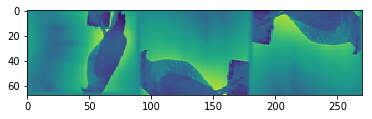

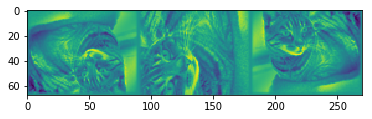

In [4]:
imgs_mt = sio.loadmat('images_natimg2800_all.mat')
imgs = imgs_mt['imgs'] 
plt.imshow(imgs[:,:,1])
plt.show()
plt.imshow(imgs[:,:,300])
plt.show()

### Mouse Data: ###

mt1-3 are the data on each mouse. This includes, but is not limited to the stimuli by the neurons, identification of the stimulus, time points, cell centers and cell stats. Below I load the data and then briefly touch on the features I will be using the most.

In [84]:
#Mouse 1
mt1 = sio.loadmat('M160825_MP027_2016-12-14 .mat')
# stimulus responses
resp1 = mt1['stim'][0]['resp'][0]    # stimuli by neurons
istim1 = mt1['stim'][0]['istim'][0]   # identities of stimuli in resp, stimulus identity of each stimulus response 
spont1 = mt1['stim'][0]['spont'][0]  # timepoints by neurons
# cell information
med1 = mt1['med']                 # cell centers (X Y Z)
first_stat1 = mt1['stat'][0]     # first cell’s stats
# mt1['stat'][0]['npix']       # one example field, tells you how pixels make up the cell

#Mouse 2
mt2 = sio.loadmat('M161025_MP030_2017-05-29.mat')
#stimulus responses
resp2 = mt2['stim'][0]['resp'][0]    
istim2 = mt2['stim'][0]['istim'][0]   
spont2 = mt2['stim'][0]['spont'][0]  
# cell information
med2 = mt2['med']                 
first_stat2 = mt2['stat'][0]     
# mt2['stat'][0]['npix']       

#Mouse 3
mt3 = sio.loadmat('M170604_MP031_2017-06-28 .mat')
#stimulus responses
resp3 = mt3['stim'][0]['resp'][0]    
istim3 = mt3['stim'][0]['istim'][0]   
spont3 = mt3['stim'][0]['spont'][0]  
# cell information
med3 = mt3['med']                 
first_stat3 = mt3['stat'][0]     
# mt3['stat'][0]['npix']  

#Mouse 4
mt4 = sio.loadmat('M170717_MP033_2017-08-20 .mat')
#stimulus responses
resp4 = mt4['stim'][0]['resp'][0]    
istim4 = mt4['stim'][0]['istim'][0]   
spont4 = mt4['stim'][0]['spont'][0]  
# cell information
med4 = mt4['med']                 
first_stat4 = mt4['stat'][0]     
# mt3['stat'][0]['npix']  

### Stimulus Response :###

The responses were measured from resonnance scanning two pohoton calcium microscopy over the V1. The average stimulus response of each neuron (stim presentations x neurons) were averaged over 2 time bins and are aligned to the onset of the plane in which each neuron lives. These are in the order in which the stimuli were presented. This means that each image has a minimum of 2 stimulus responses per mouse with each stimulus composed of ~10,000 neurons.

In [427]:
resp1[0], resp1.shape

(array([ 194.97357178,    0.        ,   53.40874481, ...,    0.        ,
           0.        ,    0.        ], dtype=float32), (5426, 11449))

### Stimulus Identity :###

The stimulus (image) identity of each response above. Each row of ~10,000 neurons is matched with an image.

In [428]:
istim1, istim1.shape

(array([[   3],
        [ 251],
        [1240],
        ..., 
        [1371],
        [2205],
        [2646]], dtype=uint16), (5426, 1))

### Neuron Position :###
    
Each neurons has an estimated (x,y,z) location in 3d space. I did not have the computational power to work with this data, but I think it would be very interesting to use the point to construct 3D models.


In [429]:
med1

array([[338,  10,  70],
       [307,  18,  70],
       [ 92,  20,  70],
       ..., 
       [640, 786, 420],
       [646, 810, 420],
       [658, 878, 420]], dtype=uint16)

# 2. Data Exploration #


## A: Sparsity##
Many models deal with the issue of sparse encoding. When a stimulus is presented and a group of neurons analyzed, they usually do not all go off at once. This leads to high dimensional sparse data (Foldiak, 1). While I do not analyze spartisty in depth - Stringer found that of all the neurons only a small number of the cells were pushed more then two SDs over their baseline fireing rate (Stringer, 2).

So below I calculate the sparsity of responses for three of the mice to see the percentage of neurons that actually fired, realizing that in reality a smaller portion of their neurons are actually significant.


In [6]:
#sparsity of responses for each mouse
response_shapes = [resp1.shape, resp2.shape, resp3.shape]
non_zeros = [np.count_nonzero(resp1), np.count_nonzero(resp2), np.count_nonzero(resp3)]
for i in range(1,4):
    z = (response_shapes[i-1][0] *  response_shapes[i-1][1])
    s = (z - non_zeros[i-1])/ z
    print('M' + str(i) + ' Sparsity: ' + str(s))

M1 Sparsity: 0.5511448276989989
M2 Sparsity: 0.573243341020846
M3 Sparsity: 0.5331005633724866


## B: Responses, Image and Mouse Ordering ##

To explore the potential correlation between responses for each image for a single mouse. I grouped together the responses in order of their corresponding image using the functions below. This way I can easily access all the responses for an image based on its index.

To simplify the data I also limited the number of responses for an image to two per mouse (most had two already, so I did this to keep it consistent). I also limited the number of neurons to 10,000.

In [7]:
#returns a list of responses for single mouse, ordered by image
def stimulus_image_relation(stimulus_responses, corresponding_images):
    corresponding_images = corresponding_images.flatten()
    indices_arr = [] #indices of corresponding stimulus for each image number
    stim_per_images_arr = []
    for val in np.arange(1,2802):  
        indices_of_val = [i for i, e in enumerate(corresponding_images) if e == val]
        indices_arr.append(indices_of_val)
    for i in np.arange(0,2801):
        stim_per_image = preprocessing.normalize(stimulus_responses[indices_arr[i], ][:,:10000])
        stim_per_images_arr.append(stim_per_image)
    for i in np.arange(0,2801):
        if len(stim_per_images_arr[i]) <2:
            b = [stim_per_images_arr[i][0]]
            stim_per_images_arr[i] = np.concatenate((stim_per_images_arr[i], b))
        if len(stim_per_images_arr[i]) >2:
            c = np.concatenate(([stim_per_images_arr[i][0]], [stim_per_images_arr[i][1]]))
            stim_per_images_arr[i] = c
    return stim_per_images_arr    

In [8]:
#creates a dataframe of the mouse's ordered responses, with the matching labels of image number and mouse number
def total_mouse_df(ordered_responses, mouse):
    m_df = pd.DataFrame(np.array(ordered_responses).transpose(1,0,2).reshape(-3,np.array(ordered_responses).shape[2]))
    m_df['true_img'] = np.tile(np.repeat([np.arange(1,2802)], 1), 2)
    m_df['true_mouse'] = np.repeat([mouse], 5602)
    return m_df

In [9]:
#creates a dataframe of the mouse's ordered responses for specific images, with the matching labels of image number 
#and mouse number
def specific_responses_df(all_responses_df, images, mouse):
    m_df = all_responses_df.loc[all_responses_df['true_img'].isin(images)]
    m_df = m_df.loc[m_df['true_mouse'] == mouse]
    return m_df

**Below are some useful organizations of the data that I will be using frequently.**

In [114]:
#Mices 1-4 ordered responses to the images
m1_sr = stimulus_image_relation(resp1, istim1)
m2_sr = stimulus_image_relation(resp2, istim2)
m3_sr = stimulus_image_relation(resp3, istim3)
m4_sr = stimulus_image_relation(resp4, istim4)

# #For example below are both of mouse one's responses to the first image
m1_sr[0], m1_sr[0].shape

In [90]:
#the dataframe with all mices' responses ordered by image, with corresponding image number and mouse number
#its dimensions are  28001(imgs) * 2(2 permouse) * 3(number of mice) x 10,000(neurons) + true image, true mouse label

#4 mice
all_responses_df_4mice = total_mouse_df(m1_sr, 1).append(total_mouse_df(m2_sr, 2)).append(total_mouse_df(m3_sr, 3)).append(total_mouse_df(m4_sr, 4)).sort_values(by=['true_img', 'true_mouse'])

#3 mice
all_responses_df = total_mouse_df(m1_sr, 1).append(total_mouse_df(m2_sr, 2)).append(total_mouse_df(m3_sr, 3)).sort_values(by=['true_img', 'true_mouse'])
all_responses_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9992,9993,9994,9995,9996,9997,9998,9999,true_img,true_mouse
0,0.002403,0.000323,0.001821,0.000000,0.002103,0.000000,0.000000,0.001047,0.000000,0.005222,...,0.000000,0.000664,0.000794,0.001773,0.000000,0.000000,0.001583,0.002431,1,1
2801,0.007897,0.009245,0.002703,0.008247,0.000000,0.000000,0.000000,0.001437,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.001164,0.000704,0.000000,0.000000,0.000000,1,1
0,0.002129,0.000000,0.000000,0.000199,0.004177,0.000000,0.001195,0.000000,0.000000,0.000000,...,0.001884,0.002904,0.000000,0.003083,0.004823,0.006948,0.004344,0.002390,1,2
2801,0.000117,0.000000,0.000000,0.001489,0.000000,0.003394,0.000000,0.000000,0.006768,0.000000,...,0.000000,0.000000,0.000000,0.005417,0.000000,0.000790,0.000000,0.000180,1,2
0,0.000000,0.014534,0.007735,0.000000,0.000203,0.000000,0.000000,0.000014,0.005695,0.000000,...,0.000000,0.000000,0.000000,0.000515,0.000000,0.005176,0.000000,0.000000,1,3


## C1: PCA with 2 and 3 Components ##
PCA allows one to project high dimensional data (in this case 10,000 dimensions) down onto principal components. The code below takes the data frame with all the responses from above and applies PCA onto both two and three components for a sampled subset of images. Coloring by image and labeling by mouse number, I can better understand the inter-mouse and inter-image relationships from the clusters.

In [146]:
#runs PCA for a sampled number of images and number of components, returns the PCA dataframe and the sampled images
def run_pca(all_responses_df, num_images_sample, num_components):
    s = random.sample(range(1, 2800), num_images_sample) #chooses 5 random images to get corresponding responses from 
    sampled_df = pd.DataFrame(all_responses_df.loc[all_responses_df['true_img'].isin(s)])
    pca = PCA(n_components=num_components)
    principalComponents = pca.fit_transform(sampled_df.iloc[:,0:10000])
    var = np.sum(pca.explained_variance_ratio_)
    cols = ['Principal component ' + str(i) for i in np.arange(1,num_components + 1)]
    principalDf = pd.concat([pd.DataFrame(data = principalComponents, columns = cols),sampled_df.iloc[:,10000:10002].reset_index().drop('index', axis = 1)], axis=1)
    return [principalDf,s,var]

In [147]:
#PCA for 2 Principal components based on 10 sampled images
df_and_sample_2d = run_pca(all_responses_df, 5, 2)
finalDf_2d = df_and_sample_2d[0]
samples_2d = df_and_sample_2d[1]

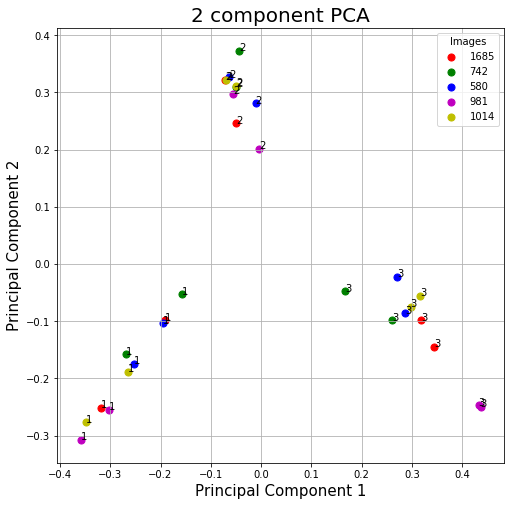

In [148]:
#Plots the 2 components, color corresponding to image and number corresponding to mouse 1,2 or 3
fig11 = plt.figure(figsize = (8,8))
ax = fig11.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

colors = ['r', 'g', 'b', 'm', 'y']
for sample, color in zip(samples_2d,colors):
    indicesToKeep = finalDf_2d['true_img'] == sample
    ax.scatter(finalDf_2d.loc[indicesToKeep, 'Principal component 1']
               , finalDf_2d.loc[indicesToKeep,'Principal component 2']
               , c = color
               , s = 50)
for i, txt in enumerate(finalDf_2d['true_mouse']):
    ax.annotate(txt, (finalDf_2d['Principal component 1'][i], finalDf_2d['Principal component 2'][i]))
ax.legend(list(samples_2d), title = 'Images', loc = 1)
ax.grid()
plt.show()

In [149]:
#PCA for 3 Principal components 
df_and_sample_3d = run_pca(all_responses_df, 5, 3)
finalDf_3d = df_and_sample_3d[0]
samples_3d = df_and_sample_3d[1]

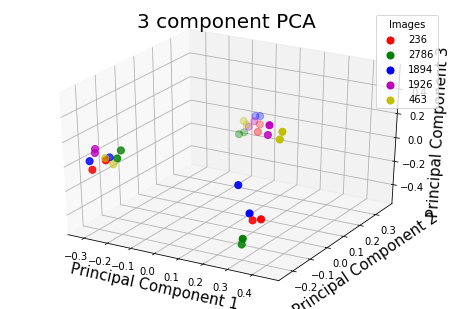

In [150]:
#plots the three principal components, as above color corresponds to image 
#if you have the right backend GUI you should be able to move the 3D plot around to better see the groupings.
fig22 = plt.figure()
ax2 = Axes3D(fig22)
colors_3d = ['r', 'g', 'b', 'm', 'y']
for sample, color in zip(samples_3d,colors_3d):
    indicesToKeep = finalDf_3d['true_img'] == sample
    ax2.scatter(finalDf_3d.loc[indicesToKeep,'Principal component 1']
               , finalDf_3d.loc[indicesToKeep,'Principal component 2']
               , finalDf_3d.loc[indicesToKeep, 'Principal component 3']
               , c = color
               , s = 50)

ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_zlabel('Principal Component 3', fontsize = 15)
ax2.set_title('3 component PCA', fontsize = 20)
    
ax2.legend(list(samples_3d), title = 'Images')
ax2.grid()

In [151]:
#captured variance 
print('Captured Varinace 2 PC: ' + str(np.sum(df_and_sample_2d[2])))
print('Captured Varinace 3 PC: ' + str(np.sum(df_and_sample_3d[2])))

Captured Varinace 2 PC: 0.12948395896
Captured Varinace 3 PC: 0.180614493134


If you run the cells above multiple times and change the number of samples, you will find that the majority of the time clusters form based on the mouse, then pairs within those clusters form based on image. This seems to imply that inter-mouse variance is more significant than inter-image variance given a single mouse. Stringer also arrived at the conclusion that "between trials there was significant trial to trial variability, but strong correlation between repeats" (Stringer, 2).

However, it is important to note that these projections from 10,000 to 2 or 3 have only captured ~13% to ~18% of the total variance of the data. Since their research illustrated how responses continued to occupy a multidimensional space, I thought it would be important to understand the effects of increasing dimensionality. Below the relationship between image samples and number of principal components becomes more clear.

## C2: Effect of Principal Components and Number of Response Samples on Variance ##

In [35]:
#returns the explained variance ratio for a number of images, with increasing principal components (1, 200)
def effect_of_projection_on_variance(all_responses_df, num_images_samples):
    targets = random.sample(range(1, 2800), num_images_samples)
    df = pd.DataFrame(all_responses_df.loc[all_responses_df['true_img'].isin(targets)])
    num_resp = num_images_samples * 2 * 3
    variances = []
    for i in np.arange(1, 410):
        pca = PCA(n_components=i)
        principalComponents = pca.fit_transform(df.iloc[:,0:10000])
        var = np.sum(pca.explained_variance_ratio_)
        num_resp = num_images_samples * 2 * 3
        variances.append([i, var])
    return np.array(variances)

In [41]:
# variances for different number of images sampled - heads up this cell takes a while to run, you can look directly at
#the plot, run them one at a time, or remove 40 and 80.
v_diff_5 = effect_of_projection_on_variance(all_responses_df, 5)
v_diff_10 = effect_of_projection_on_variance(all_responses_df, 10)
v_diff_20 = effect_of_projection_on_variance(all_responses_df, 20)
v_diff_40 = effect_of_projection_on_variance(all_responses_df, 40)
v_diff_80 = effect_of_projection_on_variance(all_responses_df, 80)

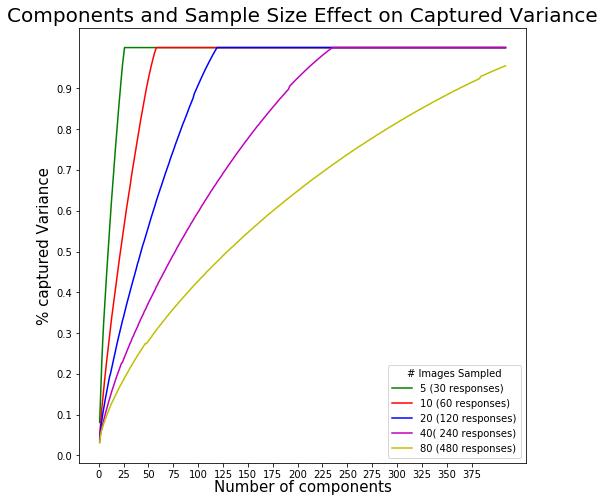

In [42]:
fig5 = plt.figure(figsize = (8,8))
ax5 = fig5.add_subplot(1,1,1) 
ax5.set_xlabel('Number of components', labelpad = .1, fontsize = 15)
ax5.set_ylabel('% captured Variance', fontsize = 15)
plt.yticks(np.arange(0, 1, .1))
plt.xticks(np.arange(0, 400, 25))
ax5.set_title('Components and Sample Size Effect on Captured Variance', fontsize = 20)

#using 10000 neurons, max 80 images
ax5.plot(v_diff_5[:,0], v_diff_5[:,1], 'g', v_diff_10[:,0], v_diff_10[:,1], 'r', v_diff_20[:,0], v_diff_20[:,1], 'b'
         , v_diff_40[:,0], v_diff_40[:,1], 'm', v_diff_80[:,0], v_diff_80[:,1], 'y')
ax5.legend([str(5) + ' (30 responses)',str(10) + ' (60 responses)', str(20)+ ' (120 responses)'
            , str(40) + '( 240 responses)', str(80) +' (480 responses)'], title = '# Images Sampled', loc = 4)
plt.show()

# #using 10000 neurons, max 20 images
# ax5.plot(v_diff_5[:,0], v_diff_5[:,1], 'g', v_diff_10[:,0], v_diff_10[:,1], 'r', v_diff_20[:,0], v_diff_20[:,1], 'b')
# ax5.legend([5*2*3,10*2*3,20*2*3], title = '# responses Sampled', loc = 4)
# plt.show()

Whereas the String paper conducts PCA to "isolate the trial to trial fluctuations in stimulus responses" (Stringer, 3), my PCA is applied directly to the neural data and measures both dimensionality of the stimulus representation and the response to response changes. Although I did not split my data the same way as the paper, some of our conclusions were similar. 

Stringer et al. find that "the amount of variance explained continued to increase as further dimensions were included" (Stringer,3). From the figure above it is clear that the number of components and responses affect the variance captured. You can see that increasing the number of components is positively correlated with the variance, as well as that as the number of responses sampled increases there is a need for higher dimensionality to capture the same amount of variance. 

There are a few reasons why it is important to be able to accurately quantify this relationship. Firstly, as was mentioned in Cumming's "The New Statistic", there is a need for results to be reproducible(Cummings, 10). Cummings highlights the importance of always understanding the population size to understand how metrics like captured variances and number of components are interrelated so that patterns found are not confined to one sample case. He also mentions that results are not always generalizable - through exploring the relationship between principal components, variance and responses it is easier for results to extend to different variations of the data. 

## D: Euclidian Distance Between Responses

Euclidian distance is usually a good metric for lower dimensional data, because distance becomes somewhat unmeasurable as dimensionality increases. From the PCA analysis above I have reduced my dimensionality from 10,000 to 2 then 3 and subsequently measured the variance - component effect up to 400 principal components. Now that I have a metric for understanding the optimal number of images and principal components, I wanted to explore the similarity or distance between responses to images. 

I expect to see that the distance between Mouse one's first and second response to image 1 is lower then the distance between responses from two different images. I sampled 30 images per mouse which is equivalent to 180 responses so  I used ~120 principal components (I got this number from looking above between the blue and pink lines and follow down to the x-axis).

In [43]:
#euclidian_comparison() takes in all the ordered responses, the number of images to be sampled and number of 
#components to run PCA with and returns a num_imgs x num_imgs matrix where the diagonal represets the similarity 
#in responses to the same image (i,i) presented to a mouse and the other indices represent the other similarities (i,j)
def euclidian_comparison(mouse, all_responses_df, num_images, num_components):
    targets = random.sample(range(1, 2800), num_images)
    df = pd.DataFrame(all_responses_df.loc[all_responses_df['true_img'].isin(targets)])
    df = pd.DataFrame(df.loc[df['true_mouse'].isin([mouse])])
    pca = PCA(n_components=num_components)
    principalComponents = pca.fit_transform(df.iloc[:,0:10000])
    dists = []
    for i in np.arange(0,num_images * 2):
        eu = []
        for j in np.arange(0,num_images * 2):
            d = distance.euclidean(principalComponents[i][0], principalComponents[j][1])
            eu.append(d)
        dists.append(eu)
    return np.array(dists)

#computes distance with self and distance with others 
def dist_with_self_and_others(eu_comparisons):
    self = []
    others = []
    for i in np.arange(len(eu_comparisons)):
        self = np.append(self,np.diagonal(eu_comparisons[i]))
    for i in np.arange(len(eu_comparisons)):
        ind = np.where(~np.eye(eu_comparisons[i].shape[0],dtype=bool))
        o = eu_comparisons[i][ind]
        others = np.append(others, o)
    return [self, others]

In [46]:
def plot_hists(num_images, num_components):
    self_size = 2*num_images
    other_size = 2*num_images * (2*num_images-1)

    eu_comparison_m1 = euclidian_comparison(1, all_responses_df, num_images, num_components)
    eu_comparison_m2 = euclidian_comparison(2, all_responses_df, num_images,num_components)
    eu_comparison_m3 = euclidian_comparison(3, all_responses_df, num_images,num_components)
    
    distances_all_mice = dist_with_self_and_others([eu_comparison_m1,eu_comparison_m2,eu_comparison_m3])
    distance_to_self = distances_all_mice[0] #euclidian distance between same picture shown twice for Mouse 1, 2 and 3 
    distance_to_others = distances_all_mice[1] #euclidian distance between different pictures for Mouse 1, 2 and 3

    fig33 = plt.figure()
    ax33 = fig33.add_subplot(1, 1, 1)
    ax33.hist(signal.resample(distance_to_self, 10000, axis=0), bins = 20, alpha=0.2, label='Dist to self')
    ax33.hist(signal.resample(distance_to_others, 10000, axis=0), bins = 20, alpha=0.2, label='Dist to Others')
    plt.legend(loc='upper right')
    ax33.set_xlabel('Distance')
    ax33.set_ylabel('Frequency')
    ax33.set_title('Distance Comparison for All Mice')

    fig44 = plt.figure()
    ax34 = fig44.add_subplot(1, 1, 1)
    ax34.hist(signal.resample(distance_to_self[:self_size], 10000, axis=0), bins = 40, alpha=0.2, label='Dist to self M1')
    ax34.hist(signal.resample(distance_to_self[self_size:2*self_size], 10000, axis=0), bins = 40, alpha=0.2, label='Dist to self M2')
    ax34.hist(signal.resample(distance_to_self[2*self_size:], 10000, axis=0), bins = 40, alpha=0.2, label='Dist to self M3')
    plt.legend(loc='upper right')
    ax34.set_xlabel('Distance')
    ax34.set_ylabel('Frequency')
    ax34.set_title('Distance to Self Comparison for Each Mouse')

    fig55 = plt.figure()
    ax35 = fig55.add_subplot(1, 1, 1)
    ax35.hist(signal.resample(distance_to_others[:other_size], 10000, axis=0), bins = 40, alpha=0.2, label='Dist to Others M1')
    ax35.hist(signal.resample(distance_to_others[other_size:2*other_size], 10000, axis=0), bins = 40, alpha=0.2, label='Dist to Others M2')
    ax35.hist(signal.resample(distance_to_others[2*other_size:], 10000, axis=0), bins = 40, alpha=0.2, label='Dist to Others M3')
    plt.legend(loc='upper right')
    ax35.set_xlabel('Distance')
    ax35.set_ylabel('Frequency')
    ax35.set_title('Distance to Others Comparison for Each Mouse')

In [47]:
w = interact(plot_hists, num_images=widgets.IntSlider(min=1,max=300,step=1,value=30)
             ,num_components=widgets.IntSlider(min=10,max=600,step=1,value=120))  

A Jupyter Widget

**Histogram 1 - Distance Comparison for All Mice:**
The first histogram has the mice data split into euclidian distances between the same image and different images across all mice. While I was expecting the distances to the same image to be much lower then the distances to the other images, they were not as extreme as I expected. I realized later that this makes sense since it was established earlier that mouse to mouse variance is higher then inter mouse variance. Therefore I decided to plot the comparisons for each mouse. 

**Histogram 2 - Distance to Self Comparison for Each Mouse:**
Keeping the same number of images at 30 and principal components at 120, the histogram shows that there is a large amount of variability in similarities to stimuli. The likeness of Mouse 1 and 3's initial response to an image varies compared to their second response, whereas Mouse 2 has higher similarity in responses to the same image. 

**Histogram 3 - Distance to Others Comparison for Each Mouse:**
Along the same lines as Histogram 2, I wanted to see if each mouse's similarity in response to other images varied in the same way as their response to the same image. Interestingly their shapes were similar. This is important because if we only saw one mouse's responses to the same stimulus we could potentially predict what its responses would look like to other images. 

**Changing Hyper-parameters:**
I mainly included the toggle to highlight the bias variance tradeoff between the number of images and principal components - following a similar logic to my plot in 2.C2. If the number of images increases, but the number of components is kept low, barely any of the data's variance is captured. Therefore it is biased towards the "distance to self comparison" being smaller since this is what actually happens in the data. Looking at Histogram 2 and 3 also illustrates how with more images and a low fixed number of components the histograms begin to look more similar - which clearly does not reflect the true variability between mice.

# 3. Models #

## A: Clustering by Response to Predator or no Predator (2 Clusters) ##

Part of the reason I chose to only use the natural images from the datset is that research suggests that animals' responses to real images differs from that of simulated objects or white noise. In "The Natural Visual Cues Eliciting Predator Avoidance in Fiddler Crabs", predator avoidance responses are monitored. While this research was to detect crabs' specific predator avoidance mechanisms, I thought that their findings were generalizable in that the crabs, like mice, respond to a combination of visual cues that correspond to distinct aspects of predators (Smolka, 3585).

With this paper in mind, my educated guess for the number of clusters was 2 - since there are 2 main types of images - predators and nature. I sampled a subset of 20 from each category which amounts to 180 responses total. I estimated about 125 principal components and then adjusted accordingly.

K-means is an unsupervised approach - meaning the data is unlabeled. For time and accuracy I selected subsets of my data that I knew corresponded to certain animals so that after I clustered the data without labels, I could compare it to the true labels. Since I know from my analysis above that the variance between mice is quite high, I decided to try to cluster the data based on a single mouse. 

In [152]:
#Predator/nature responses
cats = specific_responses_df(all_responses_df, [*range(200, 220)], 1)
snakes = specific_responses_df(all_responses_df, [*range(2680, 2700)],1)
birds = specific_responses_df(all_responses_df, [*range(10, 30)],1)
more_nature1 = specific_responses_df(all_responses_df, [*range(1000, 1030)],1)

animal_subset = pd.concat([cats,snakes,birds,more_nature1])
k_means_subset_2 = animal_subset

#correct labels for responses 
k_means_subset_2['pred/nature'] = np.repeat([np.arange(0,2)], [120,60]) #their true labels predator / nature
k_means_subset_2.shape

(180, 10003)

In [49]:
pca_for_kmeans_2 = PCA(n_components = 127)
principalComponents_kmeans_2 = pca_for_kmeans_2.fit_transform(k_means_subset_2.iloc[:,0:10000])

kmeans_2 = KMeans(n_clusters=2, random_state=0)
clusters_2 = kmeans_2.fit_predict(principalComponents_kmeans_2)

accuracy = accuracy_score(np.array(k_means_subset_2['pred/nature']), clusters_2)
explained_variance = np.sum(pca_for_kmeans_2.explained_variance_ratio_)
'accuracy: ' + str(accuracy), 'explained_variance ' + str(explained_variance)

('accuracy: 0.555555555556', 'explained_variance 0.907653981898')

I have been able to capture ~90% of the variance and have ~55% accuracy in clustering based on two clusters. While these clusters could infer a separation in responses between predators or no predators, they could also represent a separation due to something else. 

It is important to note that the boundaries for k-means clusters are always linear. So my lower accuracy, given I only have two clusters, could indicate that my boundaries are more complicated and non-linear. From class we have learnt that the responses in the visual cortex are actually a mixture of linear and non linear. In the V1, neurons respond to different gabor wavelets, mainly in response to spatial frequencies and different orientation (Lecture 5/6). While many people have used linear transformation models for the time-course of the hemodynamic responses for the V1, that does not imply that the visual reseponses themselves are all linear (Boynton, 2). 

Professor Gallant's paper on "Nonlinear V1 responses to natural scenes revealed by neural network analysis" also explains how there are complex nonlinear stimulus-responses in the V1. While his research trained a neural net to detect the non-linear relationships - I decided to try a non-linear KNN model first (Gallant, 664).

## D: K Nearest Neighbors  ##

KNN differs from K-means in that is is a supervised method. Given the labels from my training set it learns and predicts the labels on my testing set. While the decision boundaries of KNN at specific areas look linear, they actually fit to more complex shapes.

I took the responses from all three mice and ran K-nearest neighbors to try to predict the image stimuli. Initially I was splitting the testing and training set randomly, but my accuracy was quite low. After reading the paper I saw that they I trained on the first response to the stimulus and tested on the second response, so I tried that approach. With the KNN algorithm there is no way of knowing right away which value of k (Number of neighbors to use) will give the best results so I decided to plot the algorithm to see the error depending on the K chosen. 

Here I decided to use 3 of the mice instead of just one in order to see if it could classify their images correctly.

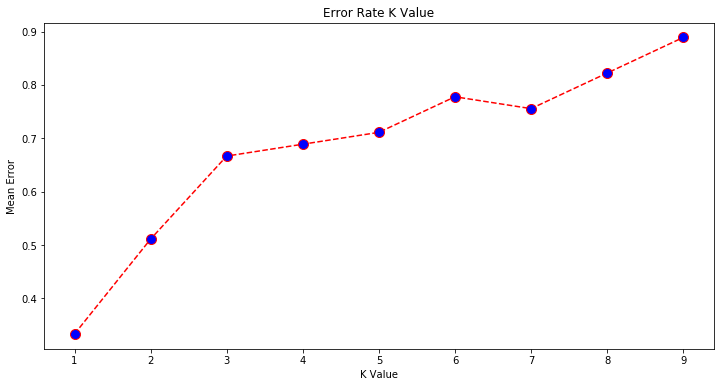

In [154]:
#sample a subset of the images for runtime purposes
ran_images = random.sample(range(1, 2800), 15)
error_compare = all_responses_df.loc[all_responses_df['true_img'].isin(ran_images)]
ktest_e =  error_compare[error_compare.index % 2 == 0]  
ktrain_e = error_compare[error_compare.index % 2 != 0] 

x_train_e = ktrain_e.iloc[:, :-2].values
y_train_e = ktrain_e['true_img'].values

x_test_e = ktest_e.iloc[:, :-2].values
y_test_e = ktest_e['true_img'].values

error = []
# Calculating error for K values between 1 and 10
for i in range(1, 10):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_e, y_train_e)
    pred_i_e = knn.predict(x_test_e)
    error.append(np.mean(pred_i_e != y_test_e))

plt.figure(figsize=(12, 6))
plt.title('Error Rate K Value')  
plt.ylabel('Mean Error')  
plt.xlabel('K Value')
plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)

Clearly the error is lowest when k_neighbors = 1. Below I run the KNN with  k = 1 and see my accuracy.

In [51]:
#training Knn on half of the responses and testing on the other half
training_k_nearest =  all_responses_df[all_responses_df.index % 2 == 0]  
testing_k_nearest = all_responses_df[all_responses_df.index % 2 != 0]  

x_train = training_k_nearest.iloc[:, :-2].values
y_train = training_k_nearest['true_img'].values

x_test = testing_k_nearest.iloc[:, :-2].values
y_test = testing_k_nearest['true_img'].values

In [52]:
classifier = KNeighborsClassifier(n_neighbors=1, metric='correlation')  
classifier.fit(x_train, y_train)  
y_pred = classifier.predict(x_test)

In [111]:
#classification report
precision,recall,fscore,support= score(y_test,y_pred,average='macro')
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('fscore: ' + str(fscore))

Precision: 0.34635587489
Recall: 0.312269427585
fscore: 0.301861204332


/Users/eleanorfleming/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


It classifies pretty well. Given 2801 possible images for each response - it correctly labels 35% percent of them when K = 1. However, with k = 1 the model is only fit to the first nearest point. This means that the model will have low bias, but high variance. To try to get better accuracy a I decided to train an SVM.

## SVM :##
SVM's can be quite computationally expensive on high dimenions, so I conducted PCA down to 200 dimensions which allowed me to have 120 responses in my training set and 120 in my testing ~ sampling 40 images.

In [54]:
sample_imgs_svm = random.sample(range(1, 2800), 40)
all_responsonses_svm = all_responses_df.loc[all_responses_df['true_img'].isin(sample_imgs_svm)]
pca_svm = PCA(n_components=200)
principalComponents_svm = pd.DataFrame(pca_svm.fit_transform(all_responsonses_svm.iloc[:,0:10000])) 

x_train_svm = principalComponents_svm[principalComponents_svm.index % 2 == 0].values
y_train_svm = all_responsonses_svm[all_responsonses_svm.index % 2 == 0]['true_img'].values

x_test_svm = principalComponents_svm[principalComponents_svm.index % 2 != 0].values
y_test_svm = all_responsonses_svm[all_responsonses_svm.index % 2 != 0]['true_img'].values

#non linear 
model_svm_nl = svm.SVC(C=1, kernel='rbf', gamma=.2) 
model_svm_nl.fit(x_train_svm, y_train_svm)
model_svm_nl.score(x_train_svm, y_train_svm)
predicted_svm_nl= model_svm_nl.predict(x_test_svm) 
print('Non-linear Accuracy: ' + str(accuracy_score(y_test_svm, predicted_svm_nl)))

#linear
model_svm = svm.SVC(C=1, kernel='linear', gamma=.2) 
model_svm.fit(x_train_svm, y_train_svm)
model_svm.score(x_train_svm, y_train_svm)
predicted_svm= model_svm.predict(x_test_svm) 
print('Linear Accuracy: ' + str(accuracy_score(y_test_svm, predicted_svm)))

Non-linear Accuracy: 0.591666666667
Linear Accuracy: 0.583333333333


My accuracy improved! 

In general SVM's outperform KNNs because they are less sensitive to outlying features. If I had maybe removed some of the outliers before running my KNN it could have improved the results. In research SVM's have proven to be very good at detecting the move relevant neurons. Because they only uses the most relevant points for finding linear separations the model is not as sensitive to these outliers. 

While I got slightly better accuracy using the Radial Basis Function compared to the linear function. There was not enough of a gap to confidently conclude which model was best.

In order to visualize the accuracy depending number of images and number of components I did a similar visualization to the PCA visualization in section 2.C2

In [96]:
def plot_svm_accuracy(num_images, all_responses_df, num_neurons):
    plt.figure(figsize=(12, 6))  
    colors = ['g', 'r', 'b', 'm', 'y']
    total = []
    for i in range(0, len(num_images)):    
        sample_imgs_svm = random.sample(range(1, 2800), num_images[i])
        all_responsonses_svm = all_responses_df.loc[all_responses_df['true_img'].isin(sample_imgs_svm)]
        acc = []
        for j in np.arange(20, 400, 20):
            pca_svm = PCA(n_components=j)
            principalComponents_svm = pd.DataFrame(pca_svm.fit_transform(all_responsonses_svm.iloc[:,0:num_neurons])) 

            x_train_svm = principalComponents_svm[principalComponents_svm.index % 2 == 0].values
            y_train_svm = all_responsonses_svm[all_responsonses_svm.index % 2 == 0]['true_img'].values

            x_test_svm = principalComponents_svm[principalComponents_svm.index % 2 != 0].values
            y_test_svm = all_responsonses_svm[all_responsonses_svm.index % 2 != 0]['true_img'].values

            model_svm = svm.SVC(C=1, kernel='sigmoid', gamma=.2) 
            model_svm.fit(x_train_svm, y_train_svm)
            model_svm.score(x_train_svm, y_train_svm)
            predicted_svm= model_svm.predict(x_test_svm) 
            acc.append(accuracy_score(y_test_svm, predicted_svm))
        total.append(acc)
        print('Max Accuracy ' +str(num_images[i]) + ' Images: ' + str(max(acc)))
        
        plt.plot(np.arange(20, 400, 20), total[i], color=colors[i], marker='o', markersize=5)
    plt.legend([str(10) + ' (30 responses)',str(20) + ' (60 responses)',str(40)+ ' (120 responses)',str(80)+ ' (240 responses)'
                ,str(160)+ ' (480 responses)'], title = '# Images Sampled for Training', loc = 4)
    if num_neurons == 10000 and len(all_responses_df) == 16806:
        plt.axvline(x=20, c ='g',linestyle='dashed'), plt.axvline(x=30,c ='r',linestyle='dashed')
        plt.axvline(x=115, c ='b',linestyle='dashed'), plt.axvline(x=225, c ='m',linestyle='dashed')
        plt.axvline(x=375, c ='y',linestyle='dashed')
    plt.title('Accuracy of SVM Based on Number of Components for Different Amounts of Images Sampled (' + str(num_neurons) + ')')  
    plt.xlabel('Number of Components')  
    plt.ylabel('% Accuracy')

Max Accuracy 10 Images: 0.666666666667
Max Accuracy 20 Images: 0.666666666667
Max Accuracy 40 Images: 0.591666666667
Max Accuracy 80 Images: 0.566666666667
Max Accuracy 160 Images: 0.529166666667


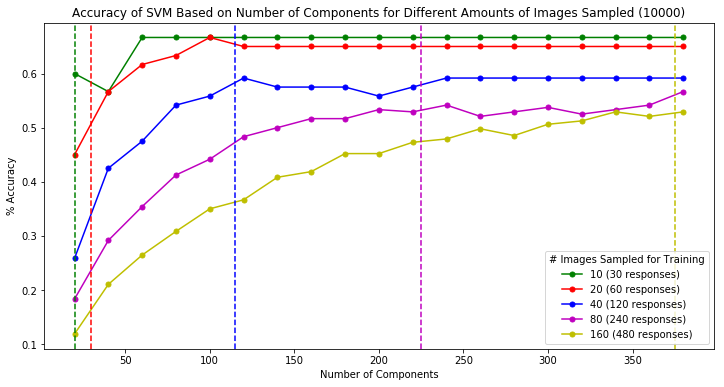

In [97]:
plot_svm_accuracy([10,20,40,80,160], all_responses_df, 10000)

The vertical lines represent the minimum components needed to reach > 90% captured variance (from Plot 2.C2).
What is interesting about this plot is that the maximum accuracy for each set of images falls at or after the number of principal components needed to capture all the variance for that many images (or total responses).

While I did not have as much time as I would have liked to explore the relationship between the number of neurons available and components etc. Below I run the SVM with 5,000 neurons instead of 10,000.

Max Accuracy 10 Images: 0.566666666667
Max Accuracy 20 Images: 0.516666666667
Max Accuracy 40 Images: 0.441666666667
Max Accuracy 80 Images: 0.441666666667
Max Accuracy 160 Images: 0.3625


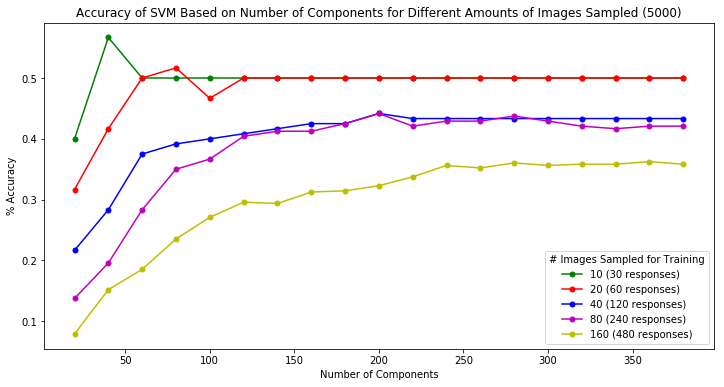

In [98]:
#SVM with 5000 neurons per responses instead of 10,000

plot_svm_accuracy([10,20,40,80,160], all_responses_df, 5000)

I was thrilled to see that accuracy went down. This could mean that given more neurons my accuracy would continue to improve if I did not sacrifice variance. Stringer found the same, stating that "Decoding accuracy did not appear to have saturated at population size 10000, suggesting that performance would further increase with more neurons" (Stringer, 2). If it is clear that more neurons are needed to improve classification accuracy, one could infer other metrics about responses in the visual cortex - like how many neurons, or combination of neurons across different parts of the cortex are truly needed to identify an image. This inference could potentially be extended to recreating the image itself. 

Computationally, I only worked with three mice for runtimes, but below I plot the effect on accuracy by running the SVM on four mice instead of three to see if my accuracy improves with more individuals.

Max Accuracy 10 Images: 0.925
Max Accuracy 20 Images: 0.6375
Max Accuracy 40 Images: 0.68125
Max Accuracy 80 Images: 0.59375
Max Accuracy 160 Images: 0.521875


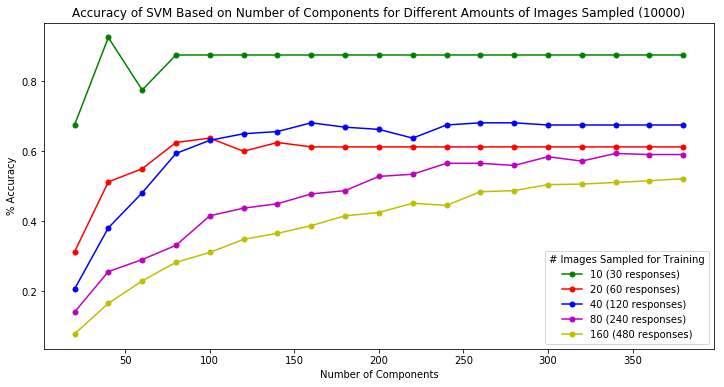

In [99]:
#for 4 mice instead of 3, 10000 neurons per response
plot_svm_accuracy([10,20,40,80,160], all_responses_df_4mice, 10000)

My accuracy greatly improved. This observation coupled with the observation that accuracy increases with more neurons could imply that my accuracy would continue to improve if I sampled more mice's responses to the same images and observed >10,000 neurons per response. 

If I were to continue with this project, I would take this information from the SVM and potentially collect more mice responses of more neurons to train a simple neural net. 

## Thank you for taking the time to read my final project! ##

## Citations: ##
API design: https://arxiv.org/abs/1309.0238 (got outlines for my models from sklearn) 

Boynton, Geoffrey M et al. “Linear systems analysis of the fMRI signal” NeuroImage vol. 62,2 (2012): 975-84.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3359416/

Carsen Stringer, Marius Pachitariu, Nicholas Steinmetz, Matteo Carandini, Kenneth D. Harris. 
High-dimensional geometry of population responses in visual cortex. bioRxiv. 
https://github.com/MouseLand/stringer-pachitariu-et-al-2018b ---
https://doi.org/10.1101/374090

Cumming, G. (2014). The New Statistics: Why and How. Psychological Science, 25(1), 7–29. https://doi.org/10.1177/0956797613504966

Foldiak, Peter and Dominik Endres (2008) Sparse coding. Scholarpedia, 3(1):2984.

Smolka, Jochen et al. “Natural visual cues eliciting predator avoidance in fiddler crabs” Proceedings. Biological sciences vol. 278,1724 (2011): 3584-92.

Galarnyk, Michael. PCA analysis. https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

Gallant JL, Prenger R1, Wu MC, David SV."Nonlinear V1 responses to natural scenes revealed by neural network analysis."
Neural Netw. 2004 Jun-Jul;17(5-6):663-79.
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.104.1229&rep=rep1&type=pdf